In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma

smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
smfPRB = sm.discrete.discrete_model.Probit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [2]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(8,8)})

# Part 3. Classification problems

### Let's talk classification. Intuitively it can be thought as a problem of separation of two colored data-clouds
### There are two distinct cases
- mixed
- separated

In [3]:
means = np.array([0,0])
covs = np.eye(2)
means, covs

(array([0, 0]),
 array([[1., 0.],
        [0., 1.]]))

In [4]:
size = 100
sample = np.random.multivariate_normal(means, covs, size=size)

### mixed

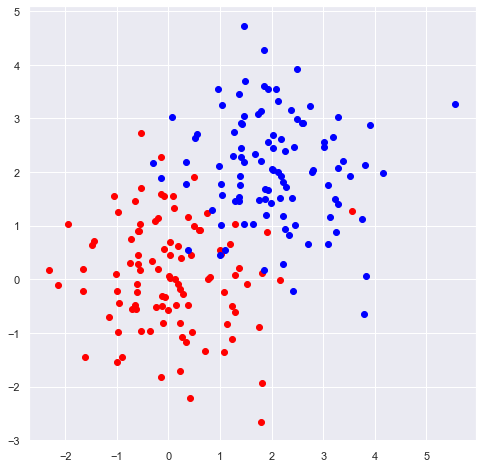

In [5]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+2, sample[:,1]+2, color = 'blue')

### separated

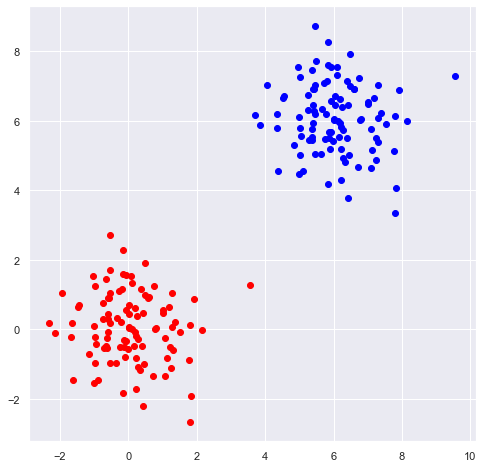

In [6]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+6, sample[:,1]+6, color = 'blue')

### In economic applications we most oftenly see the "mixed" version - when there is no perfectly separating hyperplane. So what we would like to create is a linear classificator: $$ \hat y = sgn(\alpha + \beta' x) \quad \in \{-1,1\}$$ that would tell us "blue" that is "1" if $\alpha + \beta' x > 0$, and "red" that is "-1" otherwise. Geometrically it looks like this

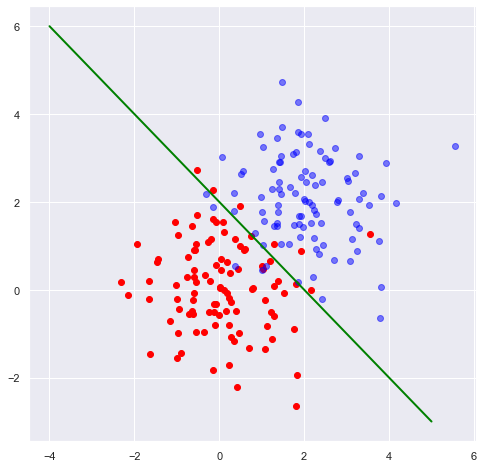

In [7]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+2, sample[:,1]+2, color = 'blue', alpha = .5)
xx = np.array([-4, -2,0,2,5])
yy = 2 - xx
plt.plot(xx, yy, color = 'green', linewidth = 2)

### In the example above I picked $\hat y = sgn(2 - x)$ by hand... but how can we automate this?

### First idea: minimize type I and type II errors. That is, we minimize the number of blue dots below the line and red dots above the line.

$$ Utility = -Loss = \sum sgn( y_i \cdot \hat y_i ) \to \max, \quad \hat y_i = \alpha + \beta' x_i , \quad y_i, \hat y_i \in \{-1,1\}$$

### When the signs of $\hat y_i, y_i$ are opposite, we suffer. When the signs are the same - we joy. However, this approach does not appreciate the "gravity" of the errors. How could we fix that?

$$ Utility = -Loss = \sum F(y_i \cdot \hat y_i) \to \max, \quad \hat y_i = \alpha + \beta' x_i , \quad y_i, \hat y_i \in \{-1,1\}$$

### We would like a smooth, monotone function $F$... symmetric around $\frac{1}{2}$. Something like $ F(z) = \frac{1}{1+e^{-z}}$.

### What we get is:
$$ Utility = \sum \log \frac{1}{1+\exp(-y_i \cdot \hat y_i)} \to \max_{\beta}$$
### or
$$ Utility = \sum_{y_i = 1} \log \frac{1}{1+\exp(-\hat y_i)} + \sum_{y_i = -1} \log \frac{1}{1+\exp(\hat y_i)} \to \max_{\beta}$$

### That just happens to be the Logit objective

# Logit as a classifier

In [8]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+2))
df['X2']= np.hstack((sample[:,1], sample[:,1]+2))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
df

X1        X2    Y
0    0.386336 -0.485829  0.0
1   -1.663235 -0.215230  0.0
2   -0.270845  1.090263  0.0
3    1.083355 -0.237175  0.0
4   -0.543747  1.038475  0.0
..        ...       ...  ...
195  2.284913  1.729969  1.0
196  2.603613  2.920958  1.0
197  2.488059  2.988798  1.0
198  2.188892  1.920226  1.0
199  1.244733  2.295170  1.0

[200 rows x 3 columns]

In [9]:
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.165505
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Sep 2021   Pseudo R-squ.:                  0.7612
Time:                        14:23:11   Log-Likelihood:                -33.101
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 1.478e-46
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9372      0.890     -5.548      0.000      -6.681      -3.193
X1             2.3054      0.433      5.329      0.000       1.457       3.153
X2             2.4099      0.471      5.116      0.000       1.487       3.333
==============================================================================
"""

### Lets see the quality of separation by the line $ 0 = \alpha + \beta ' x$ or in the 2d case by the line $$- x_2 = \frac{\alpha}{\beta_2} + \frac{\beta_1}{\beta_2} x_1$$

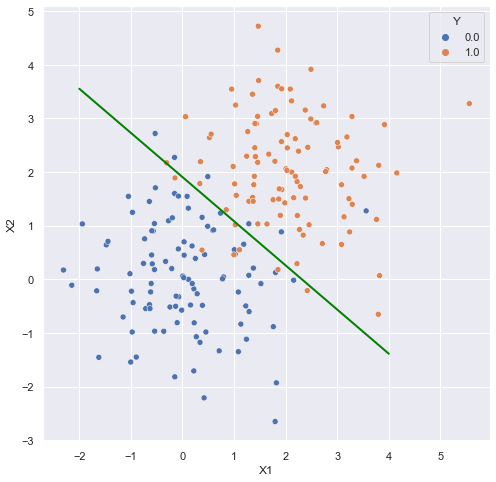

In [10]:
sb.scatterplot(x = 'X1', y='X2', data = df, hue = 'Y')
xx = np.array([-2,4])
yy = ((3.24)- xx*1.4)/1.7
plt.plot(xx, yy, color = 'green', linewidth = 2)

### Проблема логита в том, что он ожидает что облака обязательно погружены друг в друга
- погружены сильно это большая ошибка
- погруженые слабо это маленькая ошибка
- едва касаются это почти нет ошибки

### А что значит что облака далеко друг от друга?
Это значит, что в линейной формуле $$ \alpha + \beta' x + \varepsilon$$ логит будет увеличивать коэффициенты пытаясь сказать что дисперсия ошибки равна нулю, и в то же время все коэффициенты будут определены с точностью до множителя. В общем, все будет очень плохо и программа общзательно даст вам об этом знать

In [11]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit().summary()

PerfectSeparationError: Perfect separation detected, results not available

In [ ]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfPRB("Y ~ X1 + X2", data=df)
model.fit().summary()

### "Perfect separation" значит что облака сильно отделены друг от друга и коэффициенты в модели не могут быть идентифицированы с какой либо уверенностью, не говоря уже об интервалах. Конечно, можно добавить регуляризацию это формально заставит алгорим сойтись

In [ ]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit_regularized().summary()

### Однако даже с регуляризацией логит воспримет два раздельных облака как исключительно редкое явление и вообще отвратительный фит (достаточно посмотреть на интервалы), так что надо искать другую модель...